# Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
data_path = '../data/'
v_data_path='../data/v3/'

path = v_data_path

users = pd.read_csv(path+'users.csv')
books = pd.read_csv(path+'books.csv')
train_ratings = pd.read_csv(path+'train_ratings.csv')
test_ratings = pd.read_csv(path+'test_ratings.csv')

print('users shape: ', users.shape)
print('books shape: ', books.shape)
print('train_ratings shape: ', train_ratings.shape)
print('test_ratings shape: ', test_ratings.shape)

users shape:  (68092, 6)
books shape:  (149570, 11)
train_ratings shape:  (306795, 3)
test_ratings shape:  (76699, 3)


# users

## 결측치 채우기 전 v3 users의 location country-state-city 짝이 맞는지 확인

In [5]:
users.head()

,user_id,age,location_city,location_state,location_country,rating_count
0,8,24,timmins,ontario,canada,7
1,11400,49,ottawa,ontario,canada,12
2,11676,36,logansport,macedonia,russia,5520
3,67544,30,toronto,ontario,canada,7
4,85526,36,victoria,britishcolumbia,canada,120


인덱스 2 샘플만 봐도 안맞는다 . . 그냥 KNN으로 막 넣어서 그런 것 같음. city 기준으로 가장 많이 count된 조합으로 나머지 state, country를 다시 채워주자.

In [6]:
users = pd.read_csv(data_path + 'users1.csv') # knn 결측치 채우기 전, location 분해만 실행한 users 데이터

In [7]:
users = users.drop(columns='location')

city만 knn으로 결측치 채우고, 해당 city를 가지는 값들 중 가장 많이 count되는 샘플의 조합대로 state, country도 채워주자.

## KNNImputer로 결측치 처리
age와 location_city 컬럼

In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
users.loc[users[users['location_city'].notna()].index, 'location_city'] = le.fit_transform(users[users['location_city'].notna()]['location_city']) # location_city 컬럼만 결측치 제외하고 라벨인코딩

In [9]:
users.head()

,user_id,age,location_city,location_state,location_country
0,8,NaN,10627,ontario,canada
1,11400,49.0,7911,ontario,canada
2,11676,NaN,NaN,NaN,NaN
3,67544,30.0,10685,ontario,canada
4,85526,36.0,11060,britishcolumbia,canada


In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
imputed = imputer.fit_transform(users[['age', 'location_city']])
df_imputed = pd.DataFrame(imputed, columns=['age', 'location_city'])
df_imputed.info()

In [11]:
df_imputed.head()

,age,location_city
0,28.200000,10627.000000
1,49.000000,7911.000000
2,36.069873,6042.817361
3,30.000000,10685.000000
4,36.000000,11060.000000


In [12]:
df_imputed = df_imputed.astype(int)

In [13]:
df_imputed

,age,location_city
0,28,10627
1,49,7911
2,36,6042
3,30,10685
4,36,11060
...,...,...
68087,54,2609
68088,74,11060
68089,40,4981
68090,33,10975


In [14]:
users[['age', 'location_city']] = df_imputed
users.head()

,user_id,age,location_city,location_state,location_country
0,8,28,10627,ontario,canada
1,11400,49,7911,ontario,canada
2,11676,36,6042,NaN,NaN
3,67544,30,10685,ontario,canada
4,85526,36,11060,britishcolumbia,canada


In [15]:
users.isna().sum()

user_id                0
age                    0
location_city          0
location_state      1135
location_country     271
dtype: int64

In [16]:
# label 원래대로 복원
print(le.classes_)
users['location_city'] = le.inverse_transform(df_imputed['location_city'])

['0000largo' '03770elverger' '05680' ... 'zwickau' 'zwijndrecht'
 'zwingenberg']


In [17]:
users

,user_id,age,location_city,location_state,location_country
0,8,28,timmins,ontario,canada
1,11400,49,ottawa,ontario,canada
2,11676,36,logansport,NaN,NaN
3,67544,30,toronto,ontario,canada
4,85526,36,victoria,britishcolumbia,canada
...,...,...,...,...,...
68087,278376,54,danville,california,usa
68088,278621,74,victoria,delaware,canada
68089,278636,40,irvington,alabama,usa
68090,278659,33,vancouver,britishcolumbia,canada


In [18]:
print(users[users['location_state'].isna() & users['location_country'].notna()].shape)
print(users[users['location_state'].notna() & users['location_country'].isna()].shape)

(959, 5)
(95, 5)


location_state와 location_country에서 결측치가 상이하게 존재하므로, state를 먼저 채우고 그 다음 country를 채우겠습니다.

In [19]:
users[users['location_city'] == 'logansport']['location_state'].value_counts().index[0] # test

'britishcolumbia'

In [20]:
# users['location_state'][2] is np.nan # is 대신 == 사용 XXXXX!!!

In [21]:
for i, row in users[users['location_state'].isna() | users['location_country'].isna()].iterrows():
    # print(i, row['location_city'])
    try:
        if row['location_state'] is np.nan:
            # print(users[users['location_city'] == row['location_city']])
            users.loc[i, 'location_state'] = users[users['location_city'] == row['location_city']]['location_state'].value_counts().index[0] # state 채우기 # 여기서까지 location_state가 결측인 건 손수 처리, , 
        if row['location_country'] is np.nan:
            users.loc[i, 'location_country'] = users[users['location_city'] == row['location_city']]['location_state'].value_counts().index[0] # state 채우기
    except:
        pass

In [22]:
users[users['location_state'].isna()]

,user_id,age,location_city,location_state,location_country
633,271622,40,malmok,NaN,aruba
1291,88142,19,santiagocity,NaN,philippines
1334,94101,21,zambrow,NaN,poland
1442,110609,32,osaka,NaN,japan
1447,111162,18,kathmandu,NaN,nepal
...,...,...,...,...,...
67314,229756,66,prineville,NaN,oregon
67530,257375,32,vanlse,NaN,denmark
67889,265227,14,bandarseribegawan,NaN,brunei
67973,270244,21,sincity,NaN,singapore


In [23]:
users[users['location_country'].isna()]

,user_id,age,location_city,location_state,location_country
1879,181316,36,managua,NaN,NaN
2183,227295,29,llanelli,NaN,NaN
3169,28372,35,northapollo,NaN,NaN
3383,21188,39,middlevillage,NaN,NaN
4395,129474,50,fifewa,NaN,NaN
...,...,...,...,...,...
61441,177099,39,clippermills,NaN,NaN
62197,84038,69,sevenmilebeach,NaN,NaN
62670,90602,48,valemount,NaN,NaN
63537,255399,54,barcelonacatalunya,NaN,NaN


city 값만 있는 샘플들(즉, 데이터 내 다른 샘플들에서 state, country 정보를 참조할 수 없는 데이터)이 총 411개이다. 이들의 결측치는 unknown으로 대체한다.

In [24]:
users[['location_state', 'location_country']] = users[['location_state', 'location_country']].fillna('unknown')

In [25]:
users.isna().sum()

user_id             0
age                 0
location_city       0
location_state      0
location_country    0
dtype: int64

In [26]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_id           68092 non-null  int64 
 1   age               68092 non-null  int64 
 2   location_city     68092 non-null  object
 3   location_state    68092 non-null  object
 4   location_country  68092 non-null  object
dtypes: int64(2), object(3)
memory usage: 2.6+ MB


# Merge

In [27]:
merge1 = train_ratings.merge(books, how='left', on='isbn')
data = merge1.merge(users, how='inner', on='user_id')
print('merge 결과 shape: ', data.shape)

merge 결과 shape:  (306795, 17)


In [28]:
train_ratings.shape
# ratings 기록 갯수만큼 결과가 나온것을 확인 할 수 있습니다.

(306795, 3)

In [29]:
set(train_ratings['isbn']) - set(books['isbn']) 

set()

## user별 rating 횟수 추가

In [30]:
data.head()

,user_id,isbn,rating,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,category_high,age,location_city,location_state,location_country
0,8,0002005018,4,Clara Callan,Richard Bruce Wright,2001.0,Collins,http://images.amazon.com/images/P/0002005018.0...,en,actresses,"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg,others,28,timmins,ontario,canada
1,8,074322678X,4,Where You'll Find Me: And Other Stories,Ann Beattie,2002.0,Pocket,http://images.amazon.com/images/P/074322678X.0...,en,fiction,"Now back in print, Ann Beattie&#39;s finest sh...",images/074322678X.01.THUMBZZZ.jpg,fiction,28,timmins,ontario,canada
2,8,0887841740,2,The Middle Stories,Sheila Heti,2004.0,HarperBusiness,http://images.amazon.com/images/P/0887841740.0...,en,NaN,NaN,images/0887841740.01.THUMBZZZ.jpg,NaN,28,timmins,ontario,canada
3,8,1552041778,2,Jane Doe,R. J. Kaiser,1999.0,Firefly Books Ltd,http://images.amazon.com/images/P/1552041778.0...,en,NaN,NaN,images/1552041778.01.THUMBZZZ.jpg,NaN,28,timmins,ontario,canada
4,8,1567407781,6,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998.0,Llewellyn Publications,http://images.amazon.com/images/P/1567407781.0...,en,NaN,NaN,images/1567407781.01.THUMBZZZ.jpg,NaN,28,timmins,ontario,canada


In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306795 entries, 0 to 306794
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              306795 non-null  int64  
 1   isbn                 306795 non-null  object 
 2   rating               306795 non-null  int64  
 3   book_title           306795 non-null  object 
 4   book_author          306794 non-null  object 
 5   year_of_publication  306795 non-null  float64
 6   publisher            306795 non-null  object 
 7   img_url              306795 non-null  object 
 8   language             306795 non-null  object 
 9   category             185574 non-null  object 
 10  summary              187711 non-null  object 
 11  img_path             306795 non-null  object 
 12  category_high        185574 non-null  object 
 13  age                  306795 non-null  int64  
 14  location_city        306795 non-null  object 
 15  location_state   

In [32]:
rating_cnt_by_user = data.groupby('user_id')['rating'].count() # user별 rating 횟수 컬럼 추가
rating_cnt_by_user

user_id
8          7
9          1
12         1
14         2
16         1
          ..
278846     1
278849     1
278851    12
278852     1
278854     3
Name: rating, Length: 59803, dtype: int64

In [33]:
users = users.merge(rating_cnt_by_user, on='user_id', how='left')
users.columns = ['user_id', 'age', 'location_city', 'location_state', 'location_country', 'rating_count']
users

,user_id,age,location_city,location_state,location_country,rating_count
0,8,28,timmins,ontario,canada,7.0
1,11400,49,ottawa,ontario,canada,12.0
2,11676,36,logansport,britishcolumbia,britishcolumbia,5520.0
3,67544,30,toronto,ontario,canada,7.0
4,85526,36,victoria,britishcolumbia,canada,120.0
...,...,...,...,...,...,...
68087,278376,54,danville,california,usa,1.0
68088,278621,74,victoria,delaware,canada,1.0
68089,278636,40,irvington,alabama,usa,1.0
68090,278659,33,vancouver,britishcolumbia,canada,1.0


<Axes: >

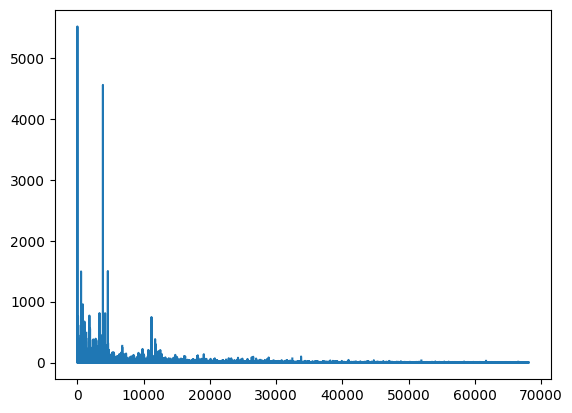

In [34]:
users['rating_count'].plot() # rating_count 분포 파악

In [35]:
users['rating_count'].describe()

count    59803.000000
mean         5.130094
std         35.517624
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max       5520.000000
Name: rating_count, dtype: float64

In [36]:
users.isna().sum()

user_id                0
age                    0
location_city          0
location_state         0
location_country       0
rating_count        8289
dtype: int64

rating_count 컬럼의 결측값은 대부분 user의 rating 기록이 없는 경우일 것이다.

따라서 rating_count 컬럼의 결측값은 0으로 채워 준다.

In [37]:
users['rating_count'].fillna(0, inplace=True)

In [38]:
users['rating_count'] = users['rating_count'].astype(int)

In [39]:
users.isna().sum()

user_id             0
age                 0
location_city       0
location_state      0
location_country    0
rating_count        0
dtype: int64

## age 결측치 처리 - KNN [실행 X] 버리는 코드. 기록을 위해 남겨둠

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306795 entries, 0 to 306794
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              306795 non-null  int64  
 1   isbn                 306795 non-null  object 
 2   rating               306795 non-null  int64  
 3   book_title           306795 non-null  object 
 4   book_author          306794 non-null  object 
 5   year_of_publication  306795 non-null  float64
 6   publisher            306795 non-null  object 
 7   img_url              306795 non-null  object 
 8   language             306795 non-null  object 
 9   category             185574 non-null  object 
 10  summary              187711 non-null  object 
 11  img_path             306795 non-null  object 
 12  category_high        185574 non-null  object 
 13  age                  214133 non-null  float64
 14  location_city        306795 non-null  object 
 15  location_state   

In [55]:
data[['age', 'rating', 'rating_count']].corr()

,age,rating,rating_count
age,1.000000,0.022936,0.212280
rating,0.022936,1.000000,0.030054
rating_count,0.212280,0.030054,1.000000


<Axes: xlabel='age'>

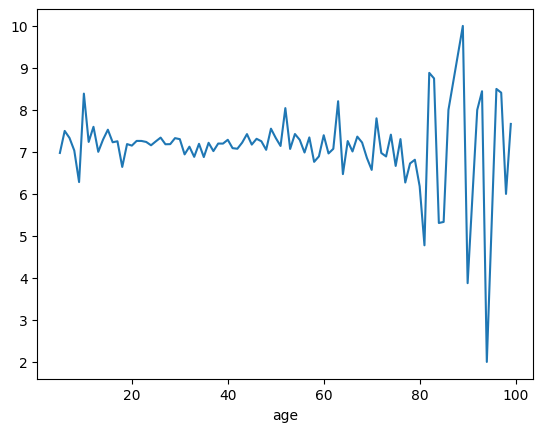

In [60]:
data.groupby('age')['rating'].mean().plot()

<Axes: xlabel='age'>

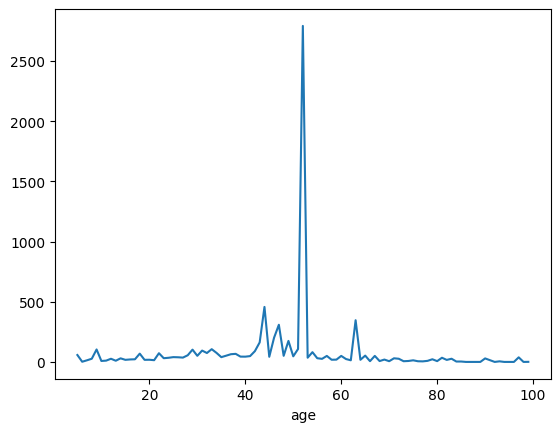

In [59]:
data.groupby('age')['rating_count'].mean().plot()

나이별로 rating 관련 컬럼들의 값 차이가 꽤 있다 -> 특정 유저의 소행,,?

rating에 따라 age 결측치를 KNNImputer로 대체

In [61]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
imputed = imputer.fit_transform(data[['age', 'rating', 'rating_count']])
df_imputed = pd.DataFrame(imputed, columns=['age', 'rating', 'rating_count'])
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306795 entries, 0 to 306794
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   age           306795 non-null  float64
 1   rating        306795 non-null  float64
 2   rating_count  306795 non-null  float64
dtypes: float64(3)
memory usage: 7.0 MB


In [63]:
df_imputed.head()

,age,rating,rating_count
0,34.0,4.0,7.0
1,34.0,4.0,7.0
2,39.4,2.0,7.0
3,39.4,2.0,7.0
4,35.0,6.0,7.0


In [64]:
df_imputed = df_imputed.astype(int)

In [65]:
df_imputed

,age,rating,rating_count
0,34,4,7
1,34,4,7
2,39,2,7
3,39,2,7
4,35,6,7
...,...,...,...
306790,54,8,1
306791,74,8,1
306792,38,2,1
306793,33,10,1


In [66]:
data['age'] = df_imputed['age']
data.head()

,user_id,isbn,rating,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,category_high,age,location_city,location_state,location_country,rating_count
0,8,0002005018,4,Clara Callan,Richard Bruce Wright,2001.0,Collins,http://images.amazon.com/images/P/0002005018.0...,en,actresses,"In a small town in Canada, Clara Callan reluct...",images/0002005018.01.THUMBZZZ.jpg,others,34,timmins,ontario,canada,7
1,8,074322678X,4,Where You'll Find Me: And Other Stories,Ann Beattie,2002.0,Pocket,http://images.amazon.com/images/P/074322678X.0...,en,fiction,"Now back in print, Ann Beattie&#39;s finest sh...",images/074322678X.01.THUMBZZZ.jpg,fiction,34,timmins,ontario,canada,7
2,8,0887841740,2,The Middle Stories,Sheila Heti,2004.0,HarperBusiness,http://images.amazon.com/images/P/0887841740.0...,en,NaN,NaN,images/0887841740.01.THUMBZZZ.jpg,NaN,39,timmins,ontario,canada,7
3,8,1552041778,2,Jane Doe,R. J. Kaiser,1999.0,Firefly Books Ltd,http://images.amazon.com/images/P/1552041778.0...,en,NaN,NaN,images/1552041778.01.THUMBZZZ.jpg,NaN,39,timmins,ontario,canada,7
4,8,1567407781,6,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998.0,Llewellyn Publications,http://images.amazon.com/images/P/1567407781.0...,en,NaN,NaN,images/1567407781.01.THUMBZZZ.jpg,NaN,35,timmins,ontario,canada,7


In [67]:
data.isna().sum()

user_id                     0
isbn                        0
rating                      0
book_title                  0
book_author                 1
year_of_publication         0
publisher                   0
img_url                     0
language                    0
category               121221
summary                119084
img_path                    0
category_high          121221
age                         0
location_city               0
location_state              0
location_country            0
rating_count                0
dtype: int64

In [68]:
users

,user_id,age,location_city,location_state,location_country,rating_count
0,8,NaN,timmins,ontario,canada,7
1,11400,49.0,ottawa,ontario,canada,12
2,11676,NaN,logansport,massachusetts,massachusetts,5520
3,67544,30.0,toronto,ontario,canada,7
4,85526,36.0,victoria,britishcolumbia,canada,120
...,...,...,...,...,...,...
68087,278376,54.0,danville,california,usa,1
68088,278621,74.0,victoria,delaware,canada,1
68089,278636,NaN,irvington,alabama,usa,1
68090,278659,33.0,vancouver,britishcolumbia,canada,1


In [70]:
users2 = users.merge(data[['user_id', 'age']], how='left', on='user_id')
users2

,user_id,age_x,location_city,location_state,location_country,rating_count,age_y
0,8,NaN,timmins,ontario,canada,7,34.0
1,8,NaN,timmins,ontario,canada,7,34.0
2,8,NaN,timmins,ontario,canada,7,39.0
3,8,NaN,timmins,ontario,canada,7,39.0
4,8,NaN,timmins,ontario,canada,7,35.0
...,...,...,...,...,...,...,...
315079,278376,54.0,danville,california,usa,1,54.0
315080,278621,74.0,victoria,delaware,canada,1,74.0
315081,278636,NaN,irvington,alabama,usa,1,38.0
315082,278659,33.0,vancouver,britishcolumbia,canada,1,33.0


In [71]:
users2.isna().sum()

user_id                 0
age_x               96410
location_city           0
location_state          0
location_country        0
rating_count            0
age_y                8289
dtype: int64

train_rating에 없던 user들이 8289명 .. 이들의 결측치를 또 처리해주어야 한다.

In [81]:
users2

,user_id,age_x,location_city,location_state,location_country,rating_count,age_y
0,8,NaN,timmins,ontario,canada,7,34.0
1,8,NaN,timmins,ontario,canada,7,34.0
2,8,NaN,timmins,ontario,canada,7,39.0
3,8,NaN,timmins,ontario,canada,7,39.0
4,8,NaN,timmins,ontario,canada,7,35.0
...,...,...,...,...,...,...,...
315079,278376,54.0,danville,california,usa,1,54.0
315080,278621,74.0,victoria,delaware,canada,1,74.0
315081,278636,NaN,irvington,alabama,usa,1,38.0
315082,278659,33.0,vancouver,britishcolumbia,canada,1,33.0


근데 보니까 같은 user에 대해서도 나이 다르게 예측 . . .여러모로 골치 아프다 그냥 users에서 해주는 걸로!!!!!!! 

## save data

In [40]:
users.to_csv(data_path + 'v4/users.csv', index=False)